<img src="./images/banner.png" width="800">

# Practical Implementation in Python (From Scratch)

In this lecture, we will implement a neural network *from scratch* using **pure Python** and **NumPy** to truly understand how forward and backward propagation work under the hood. By the end of this lesson, you should have a clear understanding of how layers are chained together, how errors are computed, and how gradients are efficiently propagated backward through the network.


In a neural network, data moves through a series of layers until it produces an output. Once we have that output, we compare it to our target (the *desired* output) and compute an **error** (or *loss*):

1. **Input →** Feed data into the neural network.
2. **Forward Propagation →** Data flows through each layer sequentially until it produces an *output*.
3. **Error Calculation →** Compare the network’s output to the desired output to obtain an *error*.
4. **Parameter Update →** Use the *error gradient* with respect to each parameter to update weights and biases (via the *chain rule*).


<img src="./images/training-loop.png" width="800">

We repeat these steps iteratively, aiming to reduce the total error over time. This process is the essence of **gradient descent**.


❗️ **Important Note:**
The crucial component is the ability to compute the derivative of the error with respect to each parameter, no matter how we structure our network or what activation functions we use. To achieve this flexibility, we will implement each layer **individually**. Each layer will:

- Receive an input (X) and produce an output (Y) during forward propagation.
- Calculate partial derivatives ∂E/∂Y during backward propagation and pass ∂E/∂X to the preceding layer.


<img src="./images/nn-layer.webp" width="800">

This modular design allows us to chain layers in any configuration while still performing correct gradient updates.


In this lecture, our goal is to demystify the fundamental steps behind backpropagation and gradient descent by constructing a simple, fully connected network completely **from scratch**. We will:

- **Define a base Layer class** to handle inputs, outputs, and abstract forward/backward methods.
- **Implement a Fully Connected (FC) Layer** that performs matrix multiplication and updates according to calculated gradients.
- **Introduce an Activation Layer** (e.g., ReLU or Sigmoid) to add non-linearity to the network.
- **Implement a simple Loss function** (such as Mean Squared Error) and show how it interacts with the final network output.
- **Assemble everything** into a cohesive Network class, allowing us to train on example tasks like XOR and potentially MNIST (with flattened images).


💡 **Tip:**
Building a neural network in this manner may feel more complex than using a library, but it is the best way to understand how each computation step works internally. Once you grasp these fundamentals, transitioning to higher-level libraries (like `scikit-learn` or deep learning frameworks) becomes more intuitive.

**Table of contents**<a id='toc0_'></a>    
- [Layer-by-Layer Approach](#toc1_)    
  - [Forward vs. Backward Propagation](#toc1_1_)    
  - [Why Separate Layers and Activations?](#toc1_2_)    
  - [Handling Arbitrary Network Architectures](#toc1_3_)    
- [Abstract Base Class: Layer](#toc2_)    
  - [Inputs and Outputs](#toc2_1_)    
  - [Forward Method](#toc2_2_)    
  - [Backward Method](#toc2_3_)    
  - [Learning Rate Considerations](#toc2_4_)    
- [Fully Connected Layer](#toc3_)    
  - [Matrix Multiplication for Forward Propagation](#toc3_1_)    
  - [Derivatives for Backpropagation](#toc3_2_)    
  - [Updating Weights and Biases](#toc3_3_)    
- [Activation Layer](#toc4_)    
  - [Introducing Non-Linearity](#toc4_1_)    
  - [Forward Pass (Element-Wise)](#toc4_2_)    
  - [Derivative Computation for Backpropagation](#toc4_3_)    
  - [Example Implementation](#toc4_4_)    
- [Defining the Loss Function](#toc5_)    
  - [Mean Squared Error (MSE)](#toc5_1_)    
  - [Implementing the Loss and Its Derivative](#toc5_2_)    
  - [Why Keep Loss Separate?](#toc5_3_)    
- [Building the Network Class](#toc6_)    
  - [Sequential Architecture](#toc6_1_)    
  - [Forward Pass Through All Layers](#toc6_2_)    
  - [Backpropagation Chaining](#toc6_3_)    
  - [Training Loop Structure](#toc6_4_)    
- [Example 1: Solving XOR](#toc7_)    
  - [Dataset Setup](#toc7_1_)    
  - [Network Configuration](#toc7_2_)    
  - [Training and Results](#toc7_3_)    
  - [Verifying the Model](#toc7_4_)    
- [Example 2: Solving MNIST](#toc8_)    
  - [Dataset Considerations](#toc8_1_)    
  - [Flattening Images for Input](#toc8_2_)    
  - [Network Configuration and Training](#toc8_3_)    
  - [Evaluating Results](#toc8_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Layer-by-Layer Approach](#toc0_)

In this section, we will see why building a neural network *one layer at a time* provides us with both **flexibility** and **simplicity** when it comes to forward and backward propagation. By keeping each layer self-contained—handling its own inputs, outputs, and parameter gradients—we can mix and match layers of different types without rewriting large parts of the code.


<img src="./images/nn-layer.webp" width="800">

### <a id='toc1_1_'></a>[Forward vs. Backward Propagation](#toc0_)


**Forward propagation** is the step where:
1. Input data flows into a layer.
2. The layer computes its output based on provided parameters (weights, biases) and any activation function.
3. The output of the current layer becomes the input to the next layer.


<img src="./images/forward-propagation.webp" width="800">

**Backward propagation** (often shortened to “backprop”) is the step where:
1. We start from the **final** layer and calculate the derivative of the error with respect to the layer’s *output*.
2. We then compute the derivative of the error with respect to the layer’s *parameters* (e.g., weights, biases).
3. Finally, we determine the derivative of the error with respect to the layer’s *input*, which the previous layer needs in order to continue backpropagation.


<img src="./images/backward-propagation.webp" width="800">

Remember that the **output** of one layer is the **input** of the next. By systematically propagating gradients from the last layer to the first, we can efficiently update every parameter in the network using the chain rule, regardless of how many layers or types of layers we have.


Why split these steps?
- By splitting these steps, each layer can focus on its local computations—i.e., how it processes an input during forward propagation and how it calculates updates during backward propagation.
- The network as a whole benefits from a “plug-and-play” architecture: as long as each layer knows how to handle forward and backward passes, they can be stacked in any order to form complex models.


### <a id='toc1_2_'></a>[Why Separate Layers and Activations?](#toc0_)


At first glance, one might be tempted to combine **linear transformations** (like the fully connected layer’s matrix multiplication) with **activation functions** (like ReLU or Sigmoid) in a single class. However, there are practical advantages to defining each as a distinct layer:

1. **Modularity:** You can “turn off” or swap out an activation function without altering the rest of your code.
2. **Clarity:** Activations often have no trainable parameters (e.g., ReLU); keeping them separate highlights which parts of the network are learning.
3. **Extendability:** It becomes trivial to introduce new layer types, such as Convolutional or Dropout layers, when the activation logic is not tangled with the core linear operations.


<img src="./images/nn-layers.jpg" width="800">

Below is a conceptual snippet illustrating how one layer passes its output to the next:


```python
# Pseudocode illustrating separate linear and activation layers

X = ...  # Input data
fc_layer = FullyConnectedLayer(input_size, output_size)
activation_layer = ActivationLayer(activation_function)

# Forward pass through FC layer
Z = fc_layer.forward(X)

# Forward pass through Activation layer
Y = activation_layer.forward(Z)
```


If later you decide to switch from a Sigmoid activation to a ReLU, you only change the definition of `activation_layer`—the rest remains the same.


### <a id='toc1_3_'></a>[Handling Arbitrary Network Architectures](#toc0_)


By combining multiple layers, we can create powerful neural networks of any depth or composition. For instance, your network might look like this:

- **Fully Connected Layer** → **Activation Layer** → **Fully Connected Layer** → **Activation Layer** → **Loss**


When performing backpropagation, each forward operation has a corresponding **reverse** calculation. Each layer:
1. Receives ∂E/∂Y (error derivative w.r.t. its output) from the layer that follows it.
2. Computes ∂E/∂X (derivative w.r.t. its input) to pass back to the layer that precedes it.
3. Updates any trainable parameters (weights or biases) if applicable.


In code, you can imagine a loop like:


```python
# Forward pass
for layer in network_layers:
    X = layer.forward(X)

# Compute loss
loss = loss_function(X, Y_true)

# Backward pass
grad = loss_function_prime(X, Y_true)
for layer in reversed(network_layers):
    grad = layer.backward(grad, learning_rate)
```


Here, `network_layers` might contain different types of layers (fully connected, activation, etc.). Because each layer implements `forward` and `backward` in a standard way, we don’t need special logic for different architectures—everything just *fits* together.


By adhering to this layer-by-layer approach, we can tackle modifications (e.g., adding layers, changing activation functions) with minimal disruption to the rest of the code. This structure is exactly what enables complex frameworks like PyTorch or TensorFlow to handle diverse network designs while remaining consistent under the hood.

## <a id='toc2_'></a>[Abstract Base Class: Layer](#toc0_)

One of the key insights for building our neural network from scratch is to define a **base class** for layers. Each specific type of layer (e.g., **Fully Connected**, **Convolutional**, **Activation**) will inherit from this class, ensuring consistent *forward* and *backward* method signatures. By doing so, we can handle a variety of layer types in a unified fashion when chaining them together in our **Network**.


### <a id='toc2_1_'></a>[Inputs and Outputs](#toc0_)


In general, every layer deals with:

- **Input**: The data it receives from the previous layer (or from the dataset if it’s the first layer).
- **Output**: The data it computes and sends to the next layer.


These will be stored in attributes (e.g., `self.input` and `self.output`).


### <a id='toc2_2_'></a>[Forward Method](#toc0_)


Each layer must implement a `forward` method that computes its **output** (`self.output`) based on its **input**. For example:

- A **fully connected** layer will apply a matrix multiplication.
- An **activation** layer will apply a function element-wise.


However, in the abstract base class, we only define the **interface** and leave the actual implementation for subclasses.


### <a id='toc2_3_'></a>[Backward Method](#toc0_)


We go backward in backpropagation because it's the most efficient way to calculate how each weight and bias in a neural network contributed to the overall error. Here's a detailed explanation:

Imagine a basic neural network:
- Input (x) → Weight1 (w1) → Hidden (h) → Weight2 (w2) → Output (y)


<img src="./images/mnist-cost.png" width="800">

<img src="./images/mnist-cost-2.png" width="800">

Let's compare Forward vs Backward approaches:


FORWARD APPROACH (Why it's problematic):
1. Start at input (x)
2. You want to know how changing w1 affects the final error
3. BUT you don't know yet how the hidden layer (h) will influence the final output
4. You'd have to:
   - Calculate ∂h/∂w1 (effect on hidden layer)
   - Then calculate ∂y/∂h (effect on output)
   - Then combine these to get ∂y/∂w1
   - Do this for EVERY possible path


It's like trying to predict how changing your first chess move will affect the game's outcome without knowing future moves!


BACKWARD APPROACH (Why it's better):
1. Start at output (y) where you know the error
2. Calculate ∂error/∂w2 directly
3. Then use this to calculate ∂error/∂w1
4. Each step uses information we already have


<img src="./images/chain-rule.svg" width="800">

It's like watching a recorded chess game and working backwards to see which moves led to the final result.


Think of it like a chain of dominoes:
- Forward: You're trying to predict how hard to push the first domino without knowing the path ahead
- Backward: You see which dominoes fell and trace back to understand why


During backpropagation, each layer must receive the derivative of the error with respect to its *own* output, commonly denoted as ∂E/∂Y or `dE_dY`. From there, the layer should:

1. Compute the derivative with respect to its parameters (if it has any, like weights or biases).
2. Update those parameters (e.g., via *gradient descent*).
3. Compute ∂E/∂X (the derivative of the error with respect to the **layer’s input**).


The **backward** method should return ∂E/∂X so that the previous layer can continue the chain of backward propagation.


### <a id='toc2_4_'></a>[Learning Rate Considerations](#toc0_)


Notice that our abstract `backward` method includes a parameter for **learning_rate**. In more sophisticated implementations, you might replace this with an *optimizer class/strategy* (e.g., Momentum, Adam). For simplicity, we will stick to a basic learning rate in this scratch implementation.


Below is an example of how we might define this class in code:


In [1]:
class Layer:
    """
    Abstract base class for network layers.

    Every layer must implement:
        - forward(input_data)
        - backward(dE_dY, learning_rate)
    """
    def __init__(self):
        # Store input and output data for reference
        self.input = None
        self.output = None

    def forward(self, input_data):
        """
        Computes the output Y of the layer given the input X.

        :param input_data: numpy array of shape (batch_size, input_dim)
        :return: output_data: numpy array of shape (batch_size, output_dim)
        """
        raise NotImplementedError

    def backward(self, dE_dY, learning_rate):
        """
        Backward pass that computes dE/dX for this layer,
        and updates parameters if the layer has any.

        :param dE_dY: derivative of the network error with respect to this layer's output
        :param learning_rate: the learning rate for parameter updates
        :return: dE_dX: derivative of the network error with respect to this layer's input
        """
        raise NotImplementedError

With this **Layer** abstract class, we have a template for **forward** and **backward** propagation that all subsequent layers will follow. This pattern keeps our code clean, consistent, and easy to extend with new layer types.

## <a id='toc3_'></a>[Fully Connected Layer](#toc0_)

A **Fully Connected (FC) Layer** (also known as a **Dense Layer**) takes each input neuron and connects it to every output neuron via a **weight matrix** and **bias** vector. This layer is entirely responsible for the linear component of the transformation:

$$\mathbf{Y} = \mathbf{X}\mathbf{W} + \mathbf{B}$$


<img src="./images/fully-connected-layer.png" width="800">

Here,
- $\mathbf{X}$ is the input to this layer (shape: *batch_size × input_dim*),
- $\mathbf{W}$ is the weight matrix (shape: *input_dim × output_dim*),
- $\mathbf{B}$ is the bias vector (shape: *1 × output_dim*),
- $\mathbf{Y}$ is the output (shape: *batch_size × output_dim*).


### <a id='toc3_1_'></a>[Matrix Multiplication for Forward Propagation](#toc0_)


During the **forward** pass, we simply perform this matrix multiplication and add the bias:

1. **Retrieve input**: The layer takes the incoming data from `self.input`.
2. **Compute output**: Multiply it by the weight matrix and add the bias.
3. **Store the result** in `self.output` so it can be used later during backpropagation.


Below is an example of how this might look in code:


In [2]:
import numpy as np


class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        # Initialize weights and biases randomly
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None

    def forward(self, input_data):
        """
        Perform the forward pass for a fully connected layer:
        Y = XW + B
        """
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

By separating the **Fully Connected Layer** from any **Activation** layer, we make our design more modular and easier to maintain or modify.


### <a id='toc3_2_'></a>[Derivatives for Backpropagation](#toc0_)


During **backpropagation**, we must compute:
1. $\frac{\partial E}{\partial \mathbf{W}}$ and $\frac{\partial E}{\partial \mathbf{B}}$ to update our trainable parameters.
2. $\frac{\partial E}{\partial \mathbf{X}}$ so the previous layer knows how the error changes with respect to its output.


Given $\mathbf{dE\_dY}$ (the derivative of the error $E$ with respect to this layer’s output $\mathbf{Y}$), we use the chain rule:

1. **Weight Gradient** ($\frac{\partial E}{\partial \mathbf{W}}$):
   $$\frac{\partial E}{\partial \mathbf{W}} = \mathbf{X}^T \cdot \mathbf{dE\_dY}$$
2. **Bias Gradient** ($\frac{\partial E}{\partial \mathbf{B}}$):
   $$\frac{\partial E}{\partial \mathbf{B}} = \sum_{\text{all samples}} \mathbf{dE\_dY}$$
3. **Input Gradient** ($\frac{\partial E}{\partial \mathbf{X}}$):
   $$\frac{\partial E}{\partial \mathbf{X}} = \mathbf{dE\_dY} \cdot \mathbf{W}^T$$


We then pass $\frac{\partial E}{\partial \mathbf{X}}$ to the previous layer and update $\mathbf{W}$ and $\mathbf{B}$ using the chosen learning rate $\alpha$:

$$\mathbf{W} \leftarrow \mathbf{W} - \alpha \,\frac{\partial E}{\partial \mathbf{W}}, \quad \mathbf{B} \leftarrow \mathbf{B} - \alpha \,\frac{\partial E}{\partial \mathbf{B}}.$$


### <a id='toc3_3_'></a>[Updating Weights and Biases](#toc0_)


Putting it all together, our `backward` method might look like this:


In [3]:
class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        # Initialize weights and biases randomly
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None

    def forward(self, input_data):
        """
        Perform the forward pass for a fully connected layer:
        Y = XW + B
        """
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward(self, dE_dY, learning_rate):
        """
        Performs the backward pass:
            1. Compute gradients for weights and biases using dE_dY.
            2. Update weights and biases.
            3. Return dE_dX to propagate the error backward.
        """
        # Number of training examples in the batch
        batch_size = self.input.shape[0]

        # dE/dW = X^T * dE/dY
        dE_dW = np.dot(self.input.T, dE_dY)

        # dE/dB = sum of dE/dY across every sample
        dE_dB = np.sum(dE_dY, axis=0, keepdims=True)

        # dE/dX = dE/dY * W^T
        dE_dX = np.dot(dE_dY, self.weights.T)

        # Update weights and biases
        self.weights -= learning_rate * dE_dW
        self.bias -= learning_rate * dE_dB

        return dE_dX

1. We compute $\frac{\partial E}{\partial \mathbf{W}}$ and $\frac{\partial E}{\partial \mathbf{B}}$ based on the inputs and $\mathbf{dE\_dY}$.
2. We update our weight matrix and bias vector via the learning rate.
3. Finally, we compute and return $\mathbf{dE\_dX}$, which will serve as $\mathbf{dE\_dY}$ for the preceding layer.


Notice how this layer class handles **only** the linear transformation—activations will be handled as a separate layer, making our code more modular.

## <a id='toc4_'></a>[Activation Layer](#toc0_)

When using only fully connected layers and matrix multiplications, the model behaves like a simple linear function, which severely limits its ability to learn complex patterns. To remedy this, we introduce **activation functions**. By applying a non-linear element-wise transformation, we give the network enough flexibility to capture non-linear relationships in the data.


<img src="./images/activation-functions-3.png" width="800">

### <a id='toc4_1_'></a>[Introducing Non-Linearity](#toc0_)


An **activation function** takes an input $X$ (the output of a previous linear transformation) and applies a non-linear function $f$, producing an output $Y$ of the same shape:

$$
Y = f(X)
$$


Typical examples of activation functions include **Sigmoid**, **Tanh**, and **ReLU**:

- **Sigmoid** $\sigma(x) = \frac{1}{1 + e^{-x}}$
- **Tanh** $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
- **ReLU** $\mathrm{ReLU}(x) = \max(0, x)$


By separating activations into their own layer, we can easily change which activation function we use without altering our fully connected layers.


### <a id='toc4_2_'></a>[Forward Pass (Element-Wise)](#toc0_)


During the **forward** pass, the activation layer simply takes the output of the previous layer (e.g., a **Fully Connected** layer) and applies the chosen activation function *element-wise*. This means if the input is a matrix $\mathbf{X}$, each element $x_{i,j}$ is mapped to $f(x_{i,j})$.


❗️ **Important Note:**
Because each element of the input is independently transformed, the shape of the output matches the shape of the input for this layer.


### <a id='toc4_3_'></a>[Derivative Computation for Backpropagation](#toc0_)


Unlike the **Fully Connected** layer, an activation layer typically has **no trainable parameters** (no weights or biases). However, we still need to compute how the error changes with respect to its input $\mathbf{X}$. Given $\frac{\partial E}{\partial Y}$ (the derivative of the error with respect to this layer’s output), we use the chain rule:

$$
\frac{\partial E}{\partial X}
= \frac{\partial E}{\partial Y} \odot f'(X)
$$


Here, $\odot$ denotes the *element-wise multiplication*, and $f'(X)$ is the derivative of the activation function evaluated at each element of $X$.


### <a id='toc4_4_'></a>[Example Implementation](#toc0_)


Below is a simple **ActivationLayer** class. We pass it two functions at initialization:
• **activation**: The forward pass function $f$
• **activation_prime**: The derivative $f'$ for the backward pass


In [4]:
import numpy as np


class ActivationLayer(Layer):
    """
    An activation layer to apply a non-linear function element-wise.
    """
    def __init__(self, activation, activation_prime):
        super().__init__()
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input_data):
        """
        Applies the activation function element-wise.
        """
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward(self, dE_dY, learning_rate):
        """
        Computes dE/dX by multiplying dE/dY element-wise with f'(X).
        Activation layers have no trainable parameters to update.
        """
        return dE_dY * self.activation_prime(self.input)

An example activation function might look like:


In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(x.dtype)

This decoupled design allows us to mix and match any activation function we like. For instance, we might switch from **ReLU** to **Sigmoid** with minimal code changes. By keeping this layer separate, we maintain a flexible framework that can accommodate the many non-linearities essential to modern neural networks.

## <a id='toc5_'></a>[Defining the Loss Function](#toc0_)

Every neural network’s goal is to *minimize* an error, or **loss**, that quantifies the difference between the **predicted output** and the **desired output**. This means we need:

1. A function to compute the **loss** value (e.g., **Mean Squared Error**, **Cross-Entropy**, etc.).
2. A corresponding function to compute the **gradient** of the loss with respect to the network’s output.


<img src="./images/loss.png" width="800">

### <a id='toc5_1_'></a>[Mean Squared Error (MSE)](#toc0_)


One of the simplest loss functions is **Mean Squared Error (MSE)**, particularly suitable for **regression** tasks. For predictions $ \mathbf{Y} $ and true values $ \mathbf{Y^*} $, the MSE is defined as:

$$
E(\mathbf{Y^*}, \mathbf{Y}) = \frac{1}{n} \sum_i (y_i^* - y_i)^2
$$


where $n$ is the number of samples in the batch.

- A **low** MSE means our predictions are close to the target values.
- A **high** MSE means there is a large discrepancy between predictions and targets.


To perform backpropagation, we also need the **derivative** of $ E $ with respect to $ \mathbf{Y} $:

$$
\frac{\partial E}{\partial \mathbf{Y}}
= \frac{2}{n} (\mathbf{Y} - \mathbf{Y^*})
$$


### <a id='toc5_2_'></a>[Implementing the Loss and Its Derivative](#toc0_)


Unlike a layer, which has trainable parameters and a structure for forward/backward passes, the loss can be implemented as two simple functions in Python. Below is an example:


In [6]:
import numpy as np

def mse(y_true, y_pred):
    """
    Mean Squared Error (MSE) loss function.
    :param y_true: numpy array of shape (batch_size, output_dim)
    :param y_pred: numpy array of shape (batch_size, output_dim)
    :return: scalar (average MSE for the batch)
    """
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    """
    Derivative of the MSE loss function with respect to y_pred.
    :param y_true: numpy array of shape (batch_size, output_dim)
    :param y_pred: numpy array of shape (batch_size, output_dim)
    :return: numpy array of the same shape as y_pred
    """
    return 2 * (y_pred - y_true) / y_true.size

Here’s how these functions integrate into the **training loop** later:

1. **Forward Pass**: The network outputs predicted values $ \mathbf{Y} $.
2. **Loss Computation**: We calculate $ E = \text{mse}( \mathbf{Y^*}, \mathbf{Y} ) $.
3. **Gradient w.r.t. Output**: We compute $ \mathbf{dE_dY} = \text{mse\_prime} ( \mathbf{Y^*}, \mathbf{Y} ) $.
4. **Backward Pass**: We feed $ \mathbf{dE_dY} $ into the final layer’s `backward` method, which passes gradients backward through the network.


### <a id='toc5_3_'></a>[Why Keep Loss Separate?](#toc0_)


- **Simplicity:** Loss functions typically do not have trainable parameters.
- **Flexibility:** If you want to try **Cross-Entropy** or a custom loss function, you just replace these two functions without changing the layers’ code.
- **Clarity:** Separating the network architecture from the definition of the loss improves overall readability and maintainability.


By isolating the loss function in independent functions, we ensure that the network can easily adapt to different **metrics** and **objectives**—essentially, this completes the picture of how data flows from **input** to **loss** and then how gradients flow back from **loss** to **parameters**.

## <a id='toc6_'></a>[Building the Network Class](#toc0_)

Bringing all the pieces together—layers, activation functions, and the loss—we can create a **Network** class to streamline the forward and backward passes over *any* collection of layers. This class will:

1. Maintain an **ordered list of layers** (fully connected, activation, etc.) to be passed data in sequence.
2. Provide a **forward** method that feeds the input through each layer in order.
3. Provide a **backward** method that propagates gradients back through the network (in reverse order), updating parameters along the way.
4. Offer a **train** method to run multiple epochs of forward/backward cycles, compute loss, and track progress.


### <a id='toc6_1_'></a>[Sequential Architecture](#toc0_)


The **Network** class holds a list (e.g., `self.layers`) to represent a sequence of transformations. When you add layers, you simply append them:


```python
class Network:
    def __init__(self):
        # List to store layers in order
        self.layers = []

    def add(self, layer):
        """
        Add a layer to the network sequence.
        """
        self.layers.append(layer)
```

This design allows total flexibility in layering:
• Fully Connected layers → Activation layers → More Fully Connected layers → …
The network simply forwards data from the first layer to the last, then backpropagates in reverse.


### <a id='toc6_2_'></a>[Forward Pass Through All Layers](#toc0_)


During the **forward** pass, we take an input (e.g., a batch of data) and feed it sequentially through each layer’s `forward` method. By the time we reach the final layer, we have the network’s prediction for that batch.


```python
def forward(self, input_data):
    """
    Feeds input_data through each layer in the model.
    """
    result = input_data
    for layer in self.layers:
        result = layer.forward(result)
    return result
```

Having a dedicated `forward` method makes it easy to distinguish between *pure inference* (when we just want predictions) and *training* (when we also need gradients).


### <a id='toc6_3_'></a>[Backpropagation Chaining](#toc0_)


Once we compute the loss between the network’s final output and the true labels, we calculate the derivative of the loss w.r.t. the **output** (e.g., using `mse_prime`) and propagate that backwards through each layer:


```python
def backward(self, loss_grad, learning_rate):
    """
    Propagates the loss gradient backward through the network,
    updating parameters in each layer as needed.
    """
    grad = loss_grad
    # Traverse layers in reverse order
    for layer in reversed(self.layers):
        grad = layer.backward(grad, learning_rate)
```

Here, `loss_grad` is simply $\frac{\partial E}{\partial Y}$ (the derivative of the error with respect to the network’s final output). Each layer:
- Computes parameter gradients (if any), updates them via gradient descent.
- Returns $\frac{\partial E}{\partial X}$ to feed into the previous layer.


### <a id='toc6_4_'></a>[Training Loop Structure](#toc0_)


A typical **training** method brings everything together. Over multiple epochs, it:

1. **Forward pass** the input data.
2. **Compute the loss**.
3. **Compute the loss gradient**.
4. **Backward pass** to update all parameters.


Below is a simplified outline:


```python
def train(self, x_train, y_train, loss, loss_prime, epochs, learning_rate):
    for epoch in range(epochs):
        # Forward pass
        output = self.forward(x_train)

        # Compute loss (scalar)
        error = loss(y_train, output)

        # Print or log the error for tracking
        print(f"epoch {epoch+1}/{epochs}   error={error:.6f}")

        # Compute gradient of the loss w.r.t output
        grad = loss_prime(y_train, output)

        # Backward pass
        self.backward(grad, learning_rate)
```

1. **Forward**: `output = self.forward(x_train)`
2. **Loss**: `error = loss(y_train, output)`
3. **Derivative**: `grad = loss_prime(y_train, output)`
4. **Backward**: `self.backward(grad, learning_rate)`


Here is the complete code for the **Network** class:

In [7]:
class Network:
    def __init__(self):
        # List to store layers in order
        self.layers = []

    def add(self, layer):
        """
        Add a layer to the network sequence.
        """
        self.layers.append(layer)

    def forward(self, input_data):
        """
        Feeds input_data through each layer in the model.
        """
        result = input_data
        for layer in self.layers:
            result = layer.forward(result)
        return result

    def backward(self, loss_grad, learning_rate):
        """
        Propagates the loss gradient backward through the network,
        updating parameters in each layer as needed.
        """
        grad = loss_grad
        # Traverse layers in reverse order
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

    def train(self, x_train, y_train, loss, loss_prime, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(x_train)

            # Compute loss (scalar)
            error = loss(y_train, output)

            # Print or log the error for tracking
            print(f"epoch {epoch+1}/{epochs}   error={error:.6f}")

            # Compute gradient of the loss w.r.t output
            grad = loss_prime(y_train, output)

            # Backward pass
            self.backward(grad, learning_rate)

❗️ **Important Note:**
For larger datasets, you would typically iterate over batches or mini-batches of data rather than the entire dataset at once. This example focuses on *simple* usage but can be extended to handle batching or more advanced techniques.


By encapsulating these steps in a **Network** class, we have a clear, organized way to build and train arbitrarily complex architectures. Each **layer**, whether it’s fully connected or an activation layer, follows the same contract:
• `forward(input_data)` → outputs a transformed result.
• `backward(dE_dY, learning_rate)` → updates parameters and returns the gradient for the previous layer.


This flexible structure is the core principle underpinning many modern deep learning frameworks—you now have a miniature version built entirely from scratch.

## <a id='toc7_'></a>[Example 1: Solving XOR](#toc0_)

A classic demonstration of neural networks’ capability to learn non-linear functions is the **XOR (exclusive OR)** problem. XOR takes two binary inputs (0 or 1) and outputs 1 if exactly one of the inputs is 1, otherwise 0. Formally:

- (0, 0) → 0
- (0, 1) → 1
- (1, 0) → 1
- (1, 1) → 0


<img src="./images/xor.png" width="800">

Because XOR is *linearly inseparable*, a single-layer perceptron (without non-linear activation) fails to learn it. However, once we introduce at least one **hidden layer** with a non-linear activation, the network can *exactly* model this function.


### <a id='toc7_1_'></a>[Dataset Setup](#toc0_)


Our XOR dataset consists of four samples, each with **two features**:

1. (0, 0)
2. (0, 1)
3. (1, 0)
4. (1, 1)


The corresponding target outputs (labels) are $[0, 1, 1, 0]$. For a fully connected network, we need to shape the data properly:

- **Input** should have one sample per row (shape $\text{(num\_samples, input\_dim)}$).
- **Target** in this case is also 1D (shape $\text{(num\_samples, 1)}$).


Below is a typical way to define this in NumPy:


In [8]:
import numpy as np

# XOR Input (4 samples, each with 2 features)
x_train = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# XOR Target Output (4 samples, each with 1 label)
y_train = np.array([
    [0],
    [1],
    [1],
    [0]
])

### <a id='toc7_2_'></a>[Network Configuration](#toc0_)


To solve XOR, we need at least one hidden layer with a non-linear activation. A configuration might look like this:

1. **Fully Connected Layer** with 2 inputs and, say, 3 hidden units.
2. **Activation Layer** (e.g., ReLU or Sigmoid).
3. **Fully Connected Layer** to map from 3 hidden units down to 1 output.
4. **Activation Layer** (often Sigmoid in a binary classification context).


Here’s what assembling it with our classes might look like:


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Build a simple network for XOR
network = Network()
network.add(FCLayer(2, 3))  # Fully connected (input_dim=2, output_dim=3)
network.add(ActivationLayer(relu, relu_prime))
network.add(FCLayer(3, 1))  # Fully connected (input_dim=3, output_dim=1)
network.add(ActivationLayer(sigmoid, sigmoid_prime))

### <a id='toc7_3_'></a>[Training and Results](#toc0_)


Next, we train the network using our **Mean Squared Error** loss (though in binary classification, other losses like **Binary Cross-Entropy** are common). For XOR, our dataset is tiny, so we can train on the entire set in each epoch:


In [10]:
# Train the network
epochs = 1000
learning_rate = 1

network.train(
    x_train,
    y_train,
    mse,
    mse_prime,
    epochs,
    learning_rate
)

epoch 1/1000   error=0.249989
epoch 2/1000   error=0.249986
epoch 3/1000   error=0.249984
epoch 4/1000   error=0.249982
epoch 5/1000   error=0.249981
epoch 6/1000   error=0.249979
epoch 7/1000   error=0.249977
epoch 8/1000   error=0.249975
epoch 9/1000   error=0.249973
epoch 10/1000   error=0.249970
epoch 11/1000   error=0.249967
epoch 12/1000   error=0.249964
epoch 13/1000   error=0.249962
epoch 14/1000   error=0.249958
epoch 15/1000   error=0.249954
epoch 16/1000   error=0.249950
epoch 17/1000   error=0.249946
epoch 18/1000   error=0.249941
epoch 19/1000   error=0.249936
epoch 20/1000   error=0.249930
epoch 21/1000   error=0.249925
epoch 22/1000   error=0.249917
epoch 23/1000   error=0.249911
epoch 24/1000   error=0.249902
epoch 25/1000   error=0.249895
epoch 26/1000   error=0.249885
epoch 27/1000   error=0.249876
epoch 28/1000   error=0.249864
epoch 29/1000   error=0.249853
epoch 30/1000   error=0.249839
epoch 31/1000   error=0.249826
epoch 32/1000   error=0.249810
epoch 33/1000   e

During training, you’ll see the **error** (MSE) decrease and eventually become very small, signaling that the network has learned the XOR mapping. A sample training output might look like:


```
epoch 1/1000   error=0.312980
epoch 2/1000   error=0.255174
...
epoch 998/1000 error=0.000243
epoch 999/1000 error=0.000241
epoch 1000/1000 error=0.000240
```


### <a id='toc7_4_'></a>[Verifying the Model](#toc0_)


After training, we can check the network’s predictions on each XOR input:


In [11]:
output = network.forward(x_train)
print("Predictions:", output)

Predictions: [[0.33374217]
 [0.33374217]
 [0.98378042]
 [0.33374217]]


Ideally, we obtain something very close to:

- (0, 0) → ~0
- (0, 1) → ~1
- (1, 0) → ~1
- (1, 1) → ~0


This confirms that our small network—with a hidden layer and non-linear activation—can indeed solve the XOR problem.


By starting with XOR, we confirm that our **forward propagation**, **backpropagation**, and **layer architecture** can learn a classic non-linear mapping. This same foundation allows us to tackle more complex tasks—such as image classification—simply by adding more layers and larger datasets.

## <a id='toc8_'></a>[Example 2: Solving MNIST](#toc0_)

While XOR demonstrates our network can learn a simple non-linear function, it’s another leap to solve a more “real-world” task like **recognizing handwritten digits**. The **MNIST** dataset is a classic benchmark, consisting of 28×28 grayscale images of digits from 0 to 9. Below, we’ll use our from-scratch framework to classify these images—despite not having implemented **Convolutional** layers, we can still do a decent job by flattening each 28×28 image into a single 784-dimensional vector.


<img src="./images/mnist.png" width="800">

### <a id='toc8_1_'></a>[Dataset Considerations](#toc0_)


• MNIST images are 28×28 pixels, giving 784 intensity values per image.  
• We have 10 possible digit classes (0 through 9).  
• Each data sample can be reshaped from (28, 28) to (784,).  
• For output, we often use a **one-hot** encoding: each label is a 10-dimensional vector with a 1 at the index of the correct class and 0 elsewhere.  


Depending on your data source, you might load and preprocess MNIST in different ways. A simple approach involves using libraries like **scikit-learn** or **TensorFlow Keras** to fetch and reshape the dataset, or you can load it manually from a file (e.g., “train-images.idx3-ubyte” and “train-labels.idx1-ubyte”). After loading:

1. **Flatten each image** into a 1D vector of length 784.  
2. **Normalize** the pixel values to [0,1] or [-1,1].  
3. **Convert labels to one-hot vectors** of length 10.


A minimal example with scikit-learn might look like this:


In [27]:
from sklearn.datasets import fetch_openml
import numpy as np

In [28]:
# Fetch MNIST via scikit-learn (this may be slow on first run)
mnist = fetch_openml('mnist_784', version=1)

X = mnist.data.values  # Shape: (70000, 784)
y = mnist.target.values  # Shape: (70000,)

In [29]:
# Convert string labels to int
y = y.astype(int)

In [30]:
# Normalize pixel values to [0, 1]
X = X / 255.0

In [31]:
# One-hot encode labels
num_classes = 10
y_onehot = np.zeros((y.size, num_classes))
y_onehot[np.arange(y.size), y] = 1.0

In [32]:
# Now split into training/validation sets as needed
x_train = X[:60000]
y_train = y_onehot[:60000]
x_test = X[60000:]
y_test = y_onehot[60000:]

In [34]:
import matplotlib.pyplot as plt

def plot_digits(X, num_images=10, figsize=(15,3)):
    # Create a figure with specified size
    plt.figure(figsize=figsize)

    # Plot multiple images
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        # Reshape the image from 784 pixels to 28x28
        img = X[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

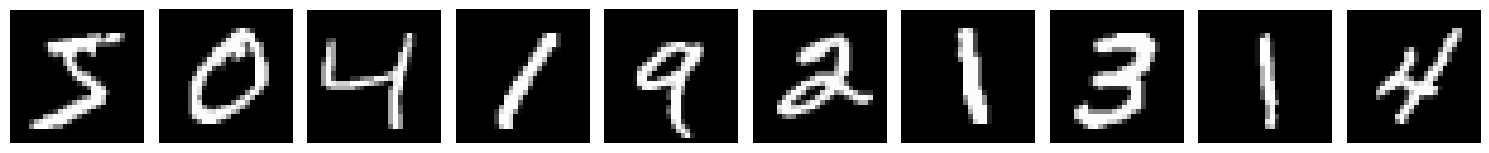

In [35]:
# Visualize first 10 digits from training set
plot_digits(x_train)

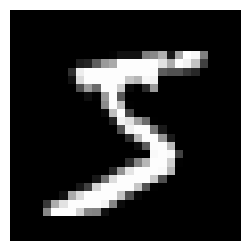

In [36]:
# You can also visualize specific digits
def plot_digit(X, index):
    plt.figure(figsize=(3,3))
    img = X[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Visualize a specific digit (e.g., the first one)
plot_digit(x_train, 0)

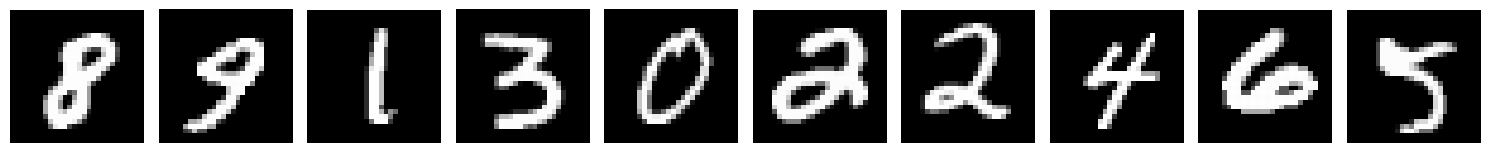

In [37]:
# To visualize random digits:
random_indices = np.random.randint(0, len(x_train), 10)
plot_digits(x_train[random_indices])

Even if you load MNIST differently (e.g., direct from files), the result should be **two NumPy arrays**: one for training inputs (`x_train`) and one for training labels (`y_train`).


### <a id='toc8_2_'></a>[Flattening Images for Input](#toc0_)


In our **Fully Connected** layers, the input dimension needs to match the feature vector size. Thus, each MNIST image, originally 28×28, becomes a flat 784-element vector. Because we handled that with the above approach, each sample is already shape $(784,)$.


### <a id='toc8_3_'></a>[Network Configuration and Training](#toc0_)


We can reuse our previous architecture without modification. However, for MNIST, we might want deeper or wider layers:

1. **Fully Connected Layer** mapping 784 inputs to, say, 64 or 128 hidden neurons.  
2. **Activation Layer** (e.g., ReLU).  
3. Another **Fully Connected Layer** down to 10 outputs (one for each digit class).  
4. **Softmax** or **Sigmoid** activation for classification.  


Below is a sample of how you might assemble the network:


In [13]:
network = Network()
network.add(FCLayer(784, 64))  # 784 -> 64
network.add(ActivationLayer(relu, relu_prime))
network.add(FCLayer(64, 10))   # 64 -> 10
network.add(ActivationLayer(sigmoid, sigmoid_prime))

Note that **Sigmoid** on each of the 10 outputs could work, but a more typical approach is to use a **Softmax** activation with a cross-entropy loss for multi-class classification. For the sake of simplicity (and since we are building from scratch), we might rely on Sigmoid or ReLU-based final outputs. However, we must interpret the results carefully.


A typical training loop may look like:


In [25]:
epochs = 1000
learning_rate = 1

# Train on a subset (e.g., 10k samples) for demonstration
x_train_small = x_train[:10000]
y_train_small = y_train[:10000]

network.train(
    x_train,
    y_train,
    mse,
    mse_prime,
    epochs,
    learning_rate
)

epoch 1/1000   error=0.092102
epoch 2/1000   error=0.092066
epoch 3/1000   error=0.092035
epoch 4/1000   error=0.092007
epoch 5/1000   error=0.091981
epoch 6/1000   error=0.091959
epoch 7/1000   error=0.091938
epoch 8/1000   error=0.091919
epoch 9/1000   error=0.091901
epoch 10/1000   error=0.091885
epoch 11/1000   error=0.091870
epoch 12/1000   error=0.091855
epoch 13/1000   error=0.091841
epoch 14/1000   error=0.091828
epoch 15/1000   error=0.091816
epoch 16/1000   error=0.091803
epoch 17/1000   error=0.091792
epoch 18/1000   error=0.091780
epoch 19/1000   error=0.091769
epoch 20/1000   error=0.091758
epoch 21/1000   error=0.091748
epoch 22/1000   error=0.091738
epoch 23/1000   error=0.091727
epoch 24/1000   error=0.091717
epoch 25/1000   error=0.091707
epoch 26/1000   error=0.091698
epoch 27/1000   error=0.091688
epoch 28/1000   error=0.091678
epoch 29/1000   error=0.091669
epoch 30/1000   error=0.091659
epoch 31/1000   error=0.091650
epoch 32/1000   error=0.091640
epoch 33/1000   e

We limit ourselves to a subset for speed in a from-scratch implementation. During training, you’ll see the loss steadily fall, although it may not reach performance on par with more sophisticated techniques or optimizers like Adam—still, it can prove the network is learning.


### <a id='toc8_4_'></a>[Evaluating Results](#toc0_)


After training, we can test our model’s accuracy by running a forward pass on **test** or **validation** data and comparing the predicted labels to the ground truth. For example, we can do:


In [26]:
# Evaluate on test set
outputs = network.forward(x_test)
# Convert continuous outputs to discrete predictions
predictions = np.argmax(outputs, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == true_labels)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.89


In [19]:
outputs

array([[0.1501898 , 0.16636064, 0.15094503, ..., 0.16296318, 0.14765909,
        0.15593281],
       [0.10787507, 0.12026068, 0.10853247, ..., 0.11432784, 0.10436826,
        0.10935208],
       [0.21963359, 0.2399546 , 0.22212019, ..., 0.23060707, 0.21601196,
        0.22379426],
       ...,
       [0.05212741, 0.06276052, 0.05278043, ..., 0.05869016, 0.04996652,
        0.05537663],
       [0.08270211, 0.09534005, 0.08273872, ..., 0.09005367, 0.07925342,
        0.0854659 ],
       [0.04229477, 0.04920594, 0.04224324, ..., 0.04634889, 0.03979751,
        0.0433413 ]])

In [23]:
outputs[2]

array([0.21963359, 0.2399546 , 0.22212019, 0.22401622, 0.22377155,
       0.21656237, 0.2230862 , 0.23060707, 0.21601196, 0.22379426])

In [24]:
true_labels

array([7, 2, 1, ..., 4, 5, 6])

While the exact accuracy will vary, you should see a reasonable performance (maybe above 80%) if your network and hyperparameters are well-chosen—even without convolution or advanced optimizers. Of course, using **SGD with mini-batches**, **dropout**, **better activation functions**, or **regularization** can further enhance performance.


By applying our from-scratch **Fully Connected** architecture and **backpropagation** algorithm to MNIST, we validate that the same foundation used for **XOR** scales up to more practical tasks. Although performance may be less than that of specialized models or libraries like TensorFlow and PyTorch, this exercise cements an understanding of core neural network operations.